# Lab Exercise 6: FSK-MSK
The purpose of this lab exercise is to simulate and analyze Frequency Shift Keying (FSK) and Minimum Shift Keying (MSK) systems. Students will compare coherent and non-coherent demodulation, calculate bit error rates, and examine the spectral properties of these modulation schemes. The exercise also includes an optional task to compare MSK and QPSK systems in terms of bit error rate and bandwidth.

## Setup

```{admonition} Live Code
Press the following button to make python code interactive. It will connect you to a kernel once it says "ready" (might take a bit, especially the first time it runs).
```

<div style="text-align: center;">
  <button title="Launch thebe" class="thebelab-button thebe-launch-button" onclick="initThebe()">Python Interactive Code</button>
</div>

#### Importing packages we will need later in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
from scipy.signal import welch
import scipy.special
from scipy.special import erfc
import math
from math import log, log2, sqrt
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, interactive, Layout, Dropdown, IntText, HBox, VBox, Output
from IPython.display import display, clear_output
from sk_dsp_comm.sigsys import add_awgn_noise
import time
print("Libraries added successfully!")

Libraries added successfully!


## Part 1:
Run code 6.1 of the notes (step-by-step, not by calling the function) for M=16 and
confirm the obtained number of errors for two different values of the normalized
signal-to-noise ratio

`````{dropdown} Code 6.1
````{tab} Python
```python
def fsk_errors(bps, Nsymb, ns, EbNo):
    """
    Input parameters
    bps: bits per symbol, Nsymb: number of simulated symbols
    ns: number of samples per symbol (oversampling)
    EbNo: normalized signal-to-noise ratio, in dB
    """
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # M frequencies in "coherent" distance (BR)
    f = fc + BR / 2 * ((np.arange(1, M + 1)) - (M + 1) / 2)

    # AWGN channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # Input data bits
    y = np.floor(2 * np.random.rand(nb, 1)).astype(int)
    x = y.reshape(-1, bps)

    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)

    # FSK signal
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k - 1) * T + tks
        s.append(np.sin(2 * np.pi * fk * tk))

    s = np.concatenate(s)

    # Add noise to the FSK (passband) signal
    s = awgn(s, SNR, 'measured')

    # FSK receiver
    # Coherent demodulation
    xr = []

    for k in range(len(s) // ns):
        tk = (k - 1) * T + tks
        sk = s[(k - 1) * ns:k * ns]
        smi = []

        for i in range(M):
            si = np.sin(2 * np.pi * f[i] * tk)
            smi.append(np.sum(sk * si))

        j = np.argmax(smi)
        xr.append(np.binary_repr(j, bps))

    xr = np.array([list(map(int, xr[i])) for i in range(len(xr))])

    # Count errors
    err = x != xr
    errors = np.sum(err)

    return errors
```
````

````{tab} Matlab
```matlab
function errors = fsk_errors(bps, Nsymb, ns, EbNo)
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %% Input parameters
    % bps: bits per symbol, Nsymb: numb of simulated symbols
    % ns: number of samples per symbol (oversampling)
    % EbNo: normalized signal-to-noise ratio, in db
    M = 2^bps; % number of different symbols
    BR = 1; % Baud Rate
    fc = 2 * M * BR; % RF frequency
    %% Derived parameters
    nb = bps * Nsymb; % number of simulated data bits
    T = 1 / BR; % one symbol period
    Ts = T / ns; % oversampling period
    % M frequencies in "coherent" distance (BR)
    f = fc + BR / 2 * ((1:M) - (M + 1) / 2);
    % awgn channel
    SNR = EbNo + 10 * log10(bps) - 10 * log10(ns / 2); % in db
    % input data bits
    y = floor(2*rand(nb, 1)); %
    x = reshape(y, bps, length(y) / bps)';
    t = [0:T:length(x(:, 1)) * T]'; % time vector on the T grid
    tks = [0:Ts:T - Ts]';
    %% FSK signal
    s = [];
    A = sqrt(2 / T / ns);
 
    for k = 1:length(x(:, 1))
        fk = f(bi2de(x(k, :)) + 1);
        tk = (k - 1) * T + tks;
        s = [s; sin(2 * pi * fk * tk)];
    end
 
    % add noise to the FSK (passband) signal
    s = awgn(s, SNR, 'measured');
    %% FSK receiver
    % coherent demodulation
    th = 0;
    xr = [];
 
    for k = 1:length(s) / ns
        tk = (k - 1) * T + tks;
        sk = s((k - 1) * ns + 1:k * ns);
        smi = [];
 
        for i = 1:M
            si = sin(2 * pi * f(i) * tk);
            smi(i) = sum(sk .* si);
        end
 
        [m, j] = max(smi);
        xr = [xr; de2bi(j - 1, bps)];
    end
 
    % count errors
    err = not(x == xr);
    errors = sum(sum(err));
end
```
````
`````

## Part 2:
Complete the above code in order to also simulate the non-coherent FSK
```{tip}
Add random phase to the received signal, before demodulation.
```

`````{dropdown} Code 6.2
````{tab} Python
```python
def fsk_errors(bps, Nsymb, ns, EbNo, mode):
    """
    Input parameters
    bps: bits per symbol
    Nsymb: number of simulated symbols
    ns: number of samples per symbol (oversampling)
    EbNo: normalized signal-to-noise ratio, in dB
    mode: 'coherent' or 'non-coherent'
    """
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    if mode == 'coherent':
        # M frequencies in "coherent" distance (BR)
        f = fc + BR / 2 * (np.arange(1, M + 1) - (M + 1) / 2)
    else:
        # M frequencies in "non-coherent" distance (BR)
        f = fc + BR * (np.arange(1, M + 1) - (M + 1) / 2)

    # AWGN channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # Input data bits
    y = np.floor(2 * np.random.rand(nb, 1)).astype(int)
    x = y.reshape((-1, bps))

    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)

    # FSK signal
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k - 1) * T + tks
        s.append(np.sin(2 * np.pi * fk * tk))

    s = np.concatenate(s)

    # Add noise to the FSK (passband) signal
    s = add_awgn_noise(s, SNR)

    # FSK receiver
    xr = []

    for k in range(len(s) // ns):
        tk = (k - 1) * T + tks
        sk = s[(k - 1) * ns:k * ns]
        smi = []

        if mode == 'coherent':
            # Coherent demodulation
            for i in range(M):
                si = np.sin(2 * np.pi * f[i] * tk)
                smi.append(np.sum(sk * si))
        else:
            # Non-coherent demodulation
            th = np.random.rand()
            sm = np.zeros(M)
            for i in range(M):
                si = np.sin(2 * np.pi * (f[i] * tk + th))
                sq = np.cos(2 * np.pi * (f[i] * tk + th))
                smi = np.sum(sk * si)
                smq = np.sum(sk * sq)
                sm[i] = np.sqrt(smi**2 + smq**2)
            smi = sm

        j = np.argmax(smi)
        xr.append(list(map(int, np.binary_repr(j, bps))))

    xr = np.array(xr)

    # Count errors
    err = x != xr
    errors = np.sum(err)

    return errors
```
````

````{tab} Matlab
```matlab
function errors = fsk_errors(bps, Nsymb, ns, EbNo, mode)
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %% Input parameters
    % bps: bits per symbol, Nsymb: number of simulated symbols
    % ns: number of samples per symbol (oversampling)
    % EbNo: normalized signal-to-noise ratio, in dB
    % mode: 'coherent' or 'non-coherent'
    M = 2^bps; % number of different symbols
    BR = 1; % Baud Rate
    fc = 2 * M * BR; % RF frequency
    
    %% Derived parameters
    nb = bps * Nsymb; % number of simulated data bits
    T = 1 / BR; % one symbol period
    Ts = T / ns; % oversampling period
    
    if strcmp(mode, 'coherent')
        % M frequencies in "coherent" distance (BR)
        f = fc + BR / 2 * ((1:M) - (M + 1) / 2);
    else
        % M frequencies in "non-coherent" distance (BR)
        f = fc + BR * ((1:M) - (M + 1) / 2);
    end
    
    % AWGN channel
    SNR = EbNo + 10 * log10(bps) - 10 * log10(ns / 2); % in dB
    
    % Input data bits
    y = floor(2 * rand(nb, 1));
    x = reshape(y, bps, length(y) / bps)';
    
    t = [0:T:length(x(:, 1)) * T]'; % time vector on the T grid
    tks = [0:Ts:T - Ts]';
    
    %% FSK signal
    s = [];
    A = sqrt(2 / T / ns);
    
    for k = 1:length(x(:, 1))
        fk = f(bi2de(x(k, :)) + 1);
        tk = (k - 1) * T + tks;
        s = [s; sin(2 * pi * fk * tk)];
    end
    
    % Add noise to the FSK (passband) signal
    s = awgn(s, SNR, 'measured');
    
    %% FSK receiver
    xr = [];
    
    for k = 1:length(s) / ns
        tk = (k - 1) * T + tks;
        sk = s((k - 1) * ns + 1:k * ns);
        smi = [];
        
        if strcmp(mode, 'coherent')
            % Coherent demodulation
            for i = 1:M
                si = sin(2 * pi * f(i) * tk);
                smi(i) = sum(sk .* si);
            end
        else
            % Non-coherent demodulation
            th = rand();
            sm = zeros(1, M);
            for i = 1:M
                si = sin(2 * pi * (f(i) * tk + th));
                sq = cos(2 * pi * (f(i) * tk + th));
                smi = sum(sk .* si);
                smq = sum(sk .* sq);
                sm(i) = sqrt(smi^2 + smq^2);
            end
            smi = sm;
        end
        
        [~, j] = max(smi);
        xr = [xr; de2bi(j - 1, bps)];
    end
    
    % Count errors
    err = not(x == xr);
    errors = sum(sum(err));
end
```
````
`````

## Part 3:
Use your new function to simulate a 16-FSK system and plot the Pb vs Eb/No curves
for coherent and non-coherent demodulation (theoretical and from simulation).

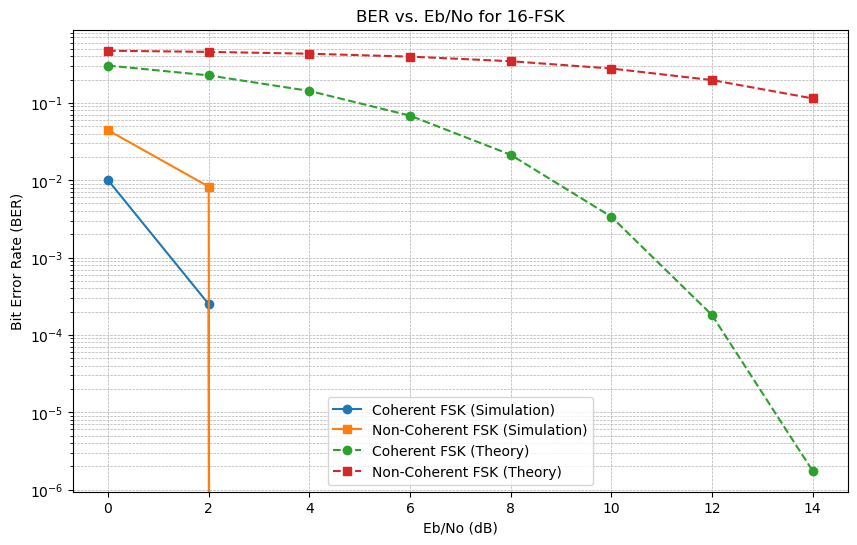

: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def bi2de(binary_array):
    return int(''.join(map(str, binary_array)), 2)

def de2bi(decimal, bps):
    return list(map(int, np.binary_repr(decimal, width=bps)))

def addAWGN(signal, SNR_dB):
    # Calculate signal power
    signal_power = np.mean(np.abs(signal) ** 2)
    
    # Calculate noise power based on SNR
    SNR_linear = 10 ** (SNR_dB / 10)
    noise_power = signal_power / SNR_linear
    
    # Generate AWGN with mean 0 and variance noise_power
    noise_real = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise_imag = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    
    # Create complex noise
    noise = noise_real + 1j * noise_imag
    
    # Add noise to the signal
    noisy_signal = signal + noise
    
    return noisy_signal

def fsk_errors_coherent(bps, Nsymb, EbNo):
    # Input parameters
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency
    ns = 80  # ns samples per symbol so that Fs=ns*Fd >=2*fmax
    
    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    f = fc + (BR / 2) * (np.arange(1, M + 1) - (M + 1) / 2)
    fmax = max(f)
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # AWGN channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # Input data bits
    y = np.random.randint(0, 2, nb)  #
    x = y.reshape((len(y) // bps, bps))
    tks = np.arange(0, T, Ts)

    # FSK signal
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = k * T + tks
        s.extend(A * np.sin(2 * np.pi * fk * tk))

    s = np.array(s)

    # Add noise to the FSK (passband) signal
    s = addAWGN(s, SNR)

    # FSK receiver
    xr = []

    for k in range(len(s) // ns):
        tk = k * T + tks
        sk = s[k * ns:(k + 1) * ns]
        smi = []

        for i in range(M):
            si = np.sin(2 * np.pi * f[i] * tk)
            smi.append(np.sum(sk * si))

        j = np.argmax(smi)
        xr.append(list(map(int, np.binary_repr(j, width=bps))))

    xr = np.array(xr).flatten()

    # Count errors
    err = np.not_equal(x.flatten(), xr)
    errors = np.sum(err)
    return errors


def fsk_errors_non_coherent(bps, Nsymb, EbNo):
    M = 2 ** bps  # Number of different symbols (modulation order)
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF Frequency
    ns = 90  # ns samples per symbol ώστε Fs=ns*Fd >=2*fmax

    nb = bps * Nsymb  # number of simulated data bits
    f = fc + BR * (np.arange(1, M+1) - (M + 1) / 2)  # M frequencies in "non-coherent" distance (BR)
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in db
    y = np.random.randint(0, 2, nb)
    x = np.reshape(y, (bps, len(y) // bps)).T
    tks = np.arange(0, T, Ts)

    s = []
    for k in range(len(x)):
        fk = f[bi2de(x[k, :])]
        tk = (k * T) + tks
        s.extend(np.sin(2 * np.pi * fk * tk))
    s = np.array(s)

    s = addAWGN(s, SNR)

    xr = []
    for k in range(len(s) // ns):
        tk = (k * T) + tks
        sk = s[k * ns:(k + 1) * ns]
        sm = []
        for i in range(M):
            th = np.random.rand() * 2 * np.pi
            si = np.sin(2 * np.pi * f[i] * tk + th)
            sq = np.cos(2 * np.pi * f[i] * tk + th)
            sm.append(np.sqrt(np.sum(sk * si) ** 2 + np.sum(sk * sq) ** 2))
        l = np.argmax(sm)
        xr.append(de2bi(l, bps))
    xr = np.array(xr)

    err = x != xr
    errors = np.sum(err)

    return errors

def theoretical_ber_coherent(M, EbNo):
    return 0.5 * np.exp(-EbNo / 2)

def theoretical_ber_non_coherent(M, EbNo):
    return 0.5 * np.exp(-EbNo / (M + 1))

# Simulation parameters
bps = 4  # for 16-FSK
Nsymb = 1000  # Reduced number of symbols to be simulated
nsamp = 80
EbNo_dB_range = np.arange(0, 15, 2)  # Reduced number of points

ber_coherent_sim = []
ber_non_coherent_sim = []
ber_coherent_theory = []
ber_non_coherent_theory = []

for EbNo_dB in EbNo_dB_range:
    errors_coherent = fsk_errors_coherent(bps, Nsymb, EbNo_dB)
    errors_non_coherent = fsk_errors_non_coherent(bps, Nsymb, EbNo_dB)
    
    ber_coherent_sim.append(errors_coherent / (Nsymb * bps))
    ber_non_coherent_sim.append(errors_non_coherent / (Nsymb * bps))
    
    EbNo = 10 ** (EbNo_dB / 10)
    ber_coherent_theory.append(theoretical_ber_coherent(16, EbNo))
    ber_non_coherent_theory.append(theoretical_ber_non_coherent(16, EbNo))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.semilogy(EbNo_dB_range, ber_coherent_sim, 'o-', label='Coherent FSK (Simulation)')
plt.semilogy(EbNo_dB_range, ber_non_coherent_sim, 's-', label='Non-Coherent FSK (Simulation)')
plt.semilogy(EbNo_dB_range, ber_coherent_theory, 'o--', label='Coherent FSK (Theory)')
plt.semilogy(EbNo_dB_range, ber_non_coherent_theory, 's--', label='Non-Coherent FSK (Theory)')

plt.xlabel('Eb/No (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs. Eb/No for 16-FSK')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Part 4:
Plot the spectrum of the bandpass signal of question 3.

In [3]:
Ts = 1 / nsamp  # oversampling period
Fs = 1 / Ts  # sampling frequency

# Plotting the spectrum of the bandpass signal
f_coherent, Pxx_coherent = welch(s_coherent.flatten(), Fs, nperseg=1024)
f_non_coherent, Pxx_non_coherent = welch(s_non_coherent.flatten(), Fs, nperseg=1024)

plt.figure(figsize=(10, 6))
plt.semilogy(f_coherent, Pxx_coherent, label='Coherent FSK Spectrum')
plt.semilogy(f_non_coherent, Pxx_non_coherent, label='Non-Coherent FSK Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.title('Power Spectral Density of the Bandpass Signal')
plt.grid(True)
plt.legend()
plt.show()

NameError: name 's_coherent' is not defined

## Part 5
```{note}
Optional. Bonus 10% to Lab grade
```

### Step 1:
Based on Code 6.2 of the notes, simulate an MSK transmission system on a
bandpass channel with a center frequency of 8 MHz and a transmission rate
of 2 Mbps. Plot the spectrum of the bandpass signal and calculate
(theoretically and by simulation) the BER, when Eb/No=10db.

### Step 2:
For the data of the previous question, find the values of the parameters of an
equivalent (in terms of bit rate) QPSK system. Compare the two systems in
terms of BER and bandwidth.
```{tip}
According to the figure below, for each odd k, the new bi (valid from the
next even k) and bq are calculated. Based on these, the two new bits are calculated,
xr(k)=bi_1*bq and xr(k+1)=bi*bq. With precoding, bit xr_1 of the previous period (k-1) is
also used.
```
![lab6_1.png](../content/images/lab6_1.png)